In [31]:
# This notebook is run using google colab therefore might not run on local istances, after putting dataset into drive and importing relevant
# And configuring the paths it should work

In [ ]:
!unzip -u "/content/drive/MyDrive/CheXpert-v1.0-small.zip"

In [ ]:
#!mv "/content/CheXpert-v1.0-small/" "/content/drive/MyDrive/CheXpert-v1.0-small/"


In [ ]:
!pip install torchviz

In [2]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import PIL.Image as Img
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random
from torchviz import make_dot

use_gpu = torch.cuda.is_available()
use_gpu

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


True

In [3]:
from IPython.display import Image 


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones", limit=False):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        image_names = []
        labels = []
        patient_nos = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            
            for line in csvReader:
                k+=1
              
                image_name= line[0]
                patient_no = image_name.split('/')[2]
                if patient_no not in patient_nos:
                  patient_nos.append(patient_no)

                if limit and len(patient_nos) + 1 > 20000:
                  break


                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_path = '/content/' + image_name
                image_names.append(image_path)
                labels.append(label)

        self.patient_nos = patient_nos
        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Img.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

    def get_patient_length(self):
      return len(self.patient_nos)

    def get_label_length(self):
      return len(self.labels)

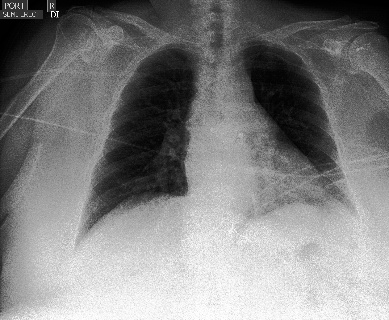

In [6]:
img_file_path = '/content/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg'
image = Img.open(img_file_path)
display(image)



In [7]:
pathFileTrain = '/content/CheXpert-v1.0-small/train.csv'
pathFileValid = '/content/CheXpert-v1.0-small/valid.csv'

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [8]:
# Neural network parameters:
nnIsTrained = False                 
nnClassCount = 14                  

trBatchSize = 64
trMaxEpoch = 3

imgtransResize = (320, 320)
imgtransCrop = 224


In [9]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)
transformSequence=transforms.Compose(transformList)

In [10]:
dataset = CheXpertDataSet(pathFileTrain ,transformSequence, policy="ones", limit=True)
datasetTest, datasetTrain = random_split(dataset, [500, len(dataset) - 500])
datasetValid = CheXpertDataSet(pathFileValid, transformSequence)            

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=False,  num_workers=8, pin_memory=False)
dataLoaderVal = DataLoader(dataset=datasetValid, batch_size=trBatchSize, shuffle=False, num_workers=8, pin_memory=False)
dataLoaderTest = DataLoader(dataset=datasetTest, num_workers=8, pin_memory=False)

In [11]:
print('patient no= ',dataset.get_patient_length())
print('image no=',len(dataset))
print('dataset label length=',dataset.get_label_length())

patient no=  20000
image no= 83049
dataset label length= 83049


In [12]:
class CheXpertTrainer():

    def train (model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.SGD(model.parameters(), lr=0.0001)
                
        #SETTINGS: LOSS
        loss = torch.nn.BCELoss(size_average=True)
        
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        
        #TRAIN THE NETWORK
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            
            batchs, losst, losse = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)


            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+'-' + launchTimestamp + '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 
       
    def epochTrain(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target) in enumerate(dataLoaderTrain):
            
            varTarget = target.to(device)
            #varInput = varInput.view(-1, 256 * 256 * 3).to(device)
            varInput = varInput.to(device)
            

            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%35==0:
                print(batchID//35, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                #print(l)
                #print(le)
                
        return batch, losstrain, losseval
    
    #-------------------------------------------------------------------------------- 
    
    def epochVal(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.to(device)

                varInput = varInput.to(device)

                varOutput = model(varInput)
                
                losstensor = loss(varOutput, target)
                lossVal += losstensor
                lossValNorm += 1
                
        outLoss = lossVal / lossValNorm
        return outLoss
  
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
        
        
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):   
        
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().to(device)
            outPRED = torch.FloatTensor().to(device)
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.to(device)
                outGT = torch.cat((outGT, target), 0).to(device)

                bs, c, h, w = input.size()
                varInput = input.to(device)
            
                out = model(varInput).to(device)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        
        print ('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print (class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

In [13]:
class Network(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.output = nn.Linear(224 * 224 * 3, out_size)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = x.to(device)
        x = x.view(-1, 224 * 224 * 3)
        x = self.output(x)
        x = self.sigm(x)
        return x

In [14]:
class MLNetwork(nn.Module):
    def __init__(self, out_size, hidden_state_neurons):
        super().__init__()
        self.l1 = nn.Linear(224 * 224 * 3, hidden_state_neurons)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_state_neurons, out_size)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = x.to(device)
        x = x.view(-1, 224 * 224 * 3)
        x = self.l1(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigm(x)
        return x

In [15]:
class MLNetwork_mult_h(nn.Module):
  def __init__(self, out_size, hidden_state_h1, hidden_state_h2):
    super().__init__()
    self.l1 = nn.Linear(224 * 224 * 3, hidden_state_h1)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_state_h1, hidden_state_h2)
    self.relu2 = nn.ReLU()
    self.output = nn.Linear(hidden_state_h2, out_size)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    print(x.size())
    x = x.view(-1, 224 * 224 * 3)
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu2(x)
    x = self.output(x)
    x = self.sigm(x)
    return x

In [16]:
class MLNetwork_mult2_h(nn.Module):
  def __init__(self, out_size, hidden_state_h1, hidden_state_h2, hidden_state_h3):
    super().__init__()
    self.l1 = nn.Linear(224 * 224 * 3, hidden_state_h1)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_state_h1, hidden_state_h2)
    self.relu2 = nn.ReLU()
    self.l3 = nn.Linear(hidden_state_h2, hidden_state_h3)
    self.relu3 = nn.ReLU()
    self.output = nn.Linear(hidden_state_h3, out_size)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    print(x.size())
    x = x.view(-1, 224 * 224 * 3)
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu2(x)
    x = self.l3(x)
    x = self.relu3(x)
    x = self.output(x)
    x = self.sigm(x)
    return x

In [17]:
class simple_CNN(nn.Module):

  def __init__(self, out_size):
    super().__init__()

    # Defining a 2D convolution layer
    self.con1 = nn.Conv2d(3, 6, 5)
    self.pol1 = nn.MaxPool2d(2, 2)
    self.con2 = nn.Conv2d(6, 16, 5)
    self.linear_layer1 = nn.Linear(16 * 122 * 122, 122)
    self.linear_layer2 = nn.Linear(122, 52)
    self.linear_layer3 = nn.Linear(52, out_size)

    self.sigm = nn.Sigmoid()

  def forward(self, x):
    x = self.con1(x)
    x = nn.functional.relu(x)
    x = self.pol1(x)
    x = self.con2(x)
    x = nn.functional.relu(x)
    x = x.view(-1, 16 * 122 * 122)
    x = self.linear_layer1(x)
    x = self.linear_layer2(x)
    x = self.linear_layer3(x)
    x = self.sigm(x)
    return x

In [18]:
class CNN(nn.Module):

  def __init__(self, out_size):
    super().__init__()
    # Defining a 2D convolution layer
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(200704, 1000)
    self.fc2 = nn.Linear(1000, 600)
    self.fc3 = nn.Linear(600, out_size)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    x = x.to(device)
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.sigm(out)
    return out

In [19]:
class CNN_v2(nn.Module):

  def __init__(self, out_size):
    super().__init__()
    # Defining a 2D convolution layer
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    
    self.layer3 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
     
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(100352, 1000)
    self.fc2 = nn.Linear(1000, 600)
    self.fc3 = nn.Linear(600, out_size)
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    x = x.to(device)
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = out.reshape(out.size(0), -1)
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    out = self.sigm(out)
    return out

In [20]:
class DenseNet121(nn.Module):
 
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


In [21]:
def plot_roc(outGT1, outPRED1):

  for i in range(nnClassCount):
      fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
      roc_auc = metrics.auc(fpr, tpr)
      f = plt.subplot(2, 7, i+1)
    
      plt.title('ROC for: ' + class_names[i])
      plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

      plt.legend(loc = 'lower right')
      plt.plot([0, 1], [0, 1],'r--')
      plt.xlim([0, 1])
      plt.ylim([0, 1])
      plt.ylabel('True Positive Rate')
      plt.xlabel('False Positive Rate')

  fig_size = plt.rcParams["figure.figsize"]
  fig_size[0] = 30
  fig_size[1] = 10
  plt.rcParams["figure.figsize"] = fig_size
  plt.show()

     |████████████████████████████████| 51kB 904kB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=f58f50bf595dab2aaf1ab52e42e2085409d25a4ebeaa5a4e351ca751b315b120
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [27]:

def plot_models(model):
  x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False).to(device)
  out = model(x)
  make_dot(out) 



In [16]:
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [44]:
model_sec_cnn = CNN(nnClassCount).cuda()
model_sec_cnn

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=14, bias=True)
  (sigm): Sigmoid()
)

In [91]:
model_mlp_300_200 = MLNetwork_mult_h(nnClassCount,300, 200).cuda()
model_mlp_900_600 = MLNetwork_mult_h(nnClassCount,900, 600).cuda()
model_mlp_1800_900 = MLNetwork_mult_h(nnClassCount,1800, 900).cuda()


print(model_mlp_300_200)
print(model_mlp_900_600)
print(model_mlp_1800_900)

MLNetwork_mult_h(
  (l1): Linear(in_features=150528, out_features=300, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=300, out_features=200, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=200, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork_mult_h(
  (l1): Linear(in_features=150528, out_features=900, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=900, out_features=600, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=600, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork_mult_h(
  (l1): Linear(in_features=150528, out_features=1800, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=1800, out_features=900, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=900, out_features=14, bias=True)
  (sigm): Sigmoid()
)


In [92]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_300_200, losst_300_200, losse_300_200 = CheXpertTrainer.train(model_mlp_300_200, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_300_200, outPRED1_300_200 = CheXpertTrainer.test(model_mlp_300_200, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
2 % batches computed
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])
70
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 2

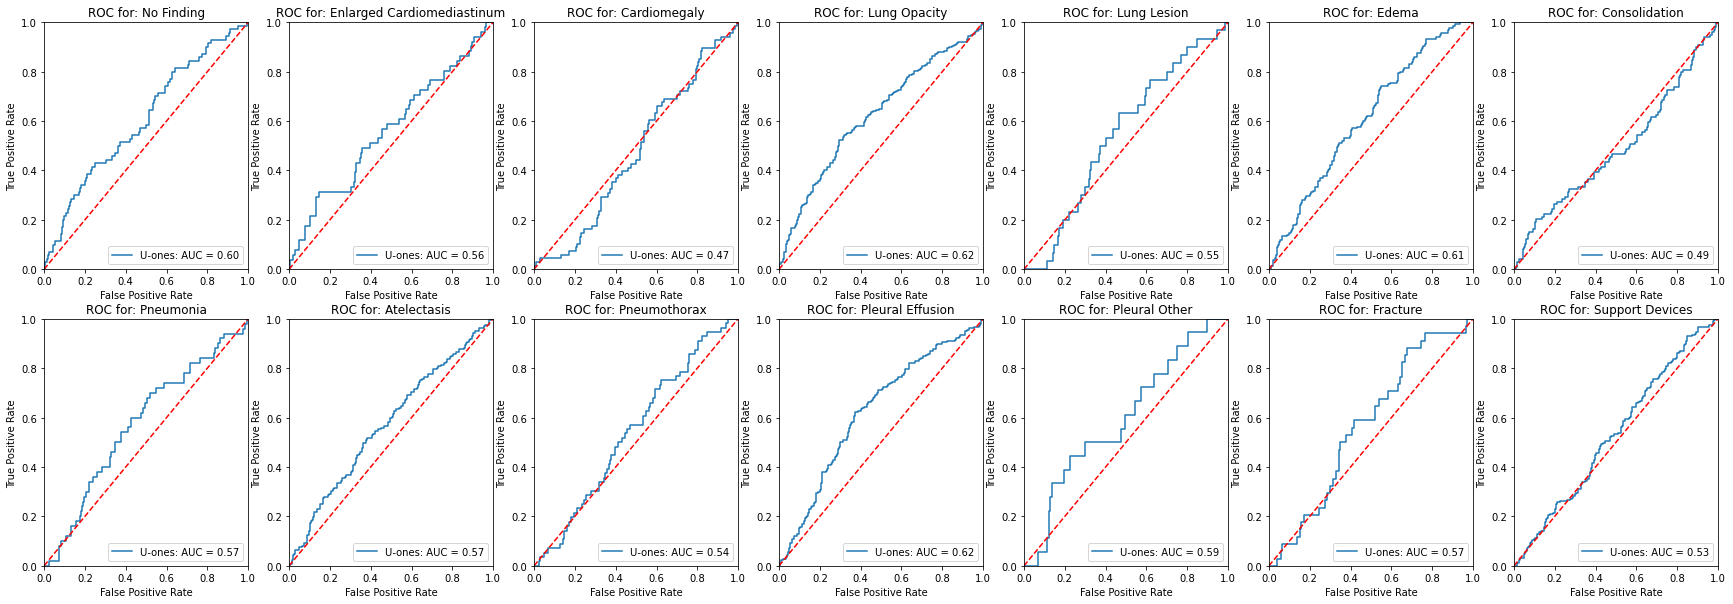

In [93]:
plot_roc(outGT1_300_200, outPRED1_300_200)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_900_600, losst_900_600, losse_900_600 = CheXpertTrainer.train(model_mlp_900_600, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_900_600, outPRED1_900_600 = CheXpertTrainer.test(model_mlp_900_600, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])
280
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64,

In [ ]:
plot_roc(outGT1_900_600, outPRED1_900_600)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_1800_900, losst_1800_900, losse_1800_900 = CheXpertTrainer.train(model_mlp_1800_900, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_1800_900, outPRED1_1800_900 = CheXpertTrainer.test(model_mlp_1800_900, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

In [ ]:
plot_roc(outGT1_1800_900, outPRED1_1800_900)

In [45]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_sec_cnn, losst_sec_cnn, losse_sec_cnn = CheXpertTrainer.train(model_sec_cnn, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_sec_cnn, outPRED1_sec_cnn = CheXpertTrainer.test(model_sec_cnn, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
2 % batches computed
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([42, 200704])
70
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])
torch.Size([64, 200704])


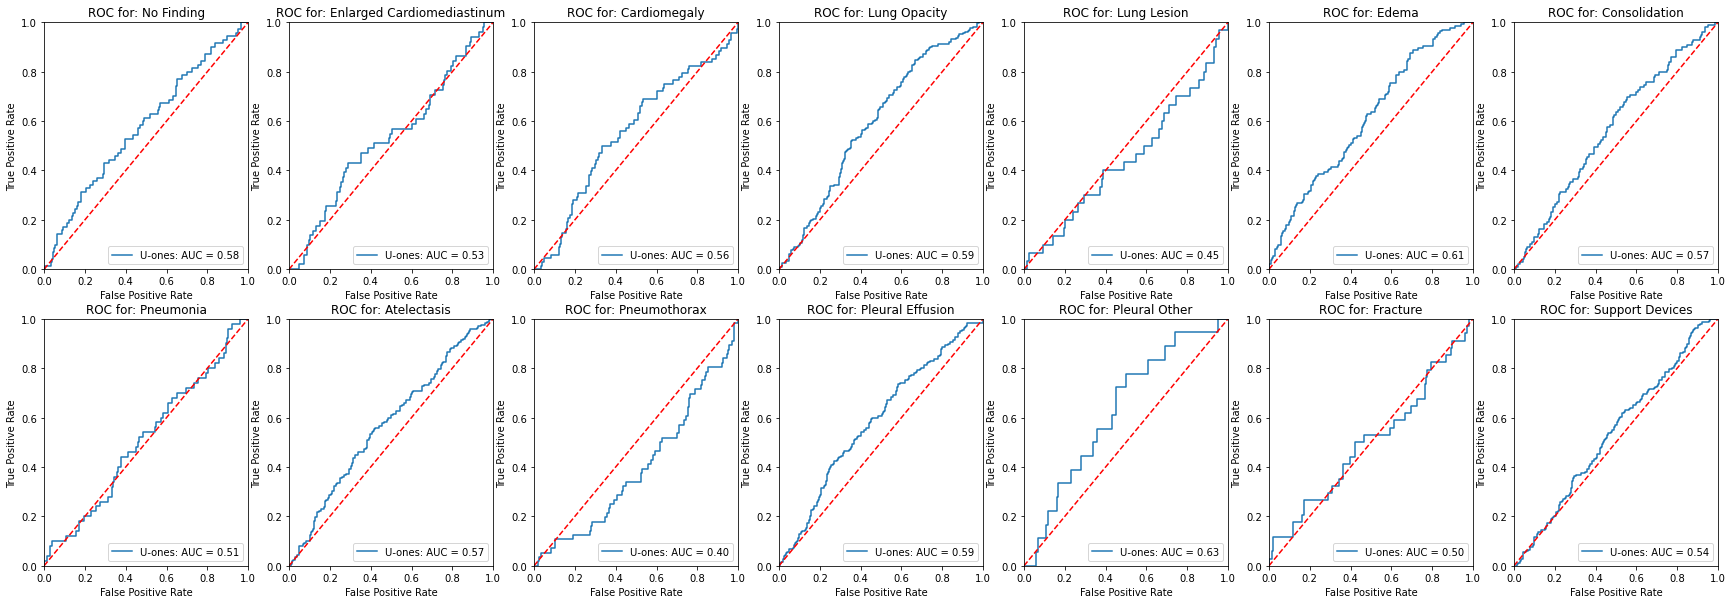

In [47]:
plot_roc(outGT1_sec_cnn, outPRED1_sec_cnn)

In [60]:
cnn_v2 = CNN_v2(nnClassCount).cuda()
cnn_v2

CNN_v2(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=14, bias=True)
  (sigm): Sigmoid()
)

In [61]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_cnn_v2, losst_cnn_v2, losse_cnn_v2 = CheXpertTrainer.train(cnn_v2, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_cnn_v2, outPRED1_cnn_v2 = CheXpertTrainer.test(cnn_v2, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
0
1 % batches computed
35
2 % batches computed
70
3 % batches computed
105
4 % batches computed
140
5 % batches computed
175
6 % batches computed
210
7 % batches computed
245
8 % batches computed
280
9 % batches computed
315
10 % batches computed
350
11 % batches computed
385
12 % batches computed
420
13 % batches computed
455
14 % batches computed
490
15 % batches computed
525
16 % batches computed
560
17 % batches computed
595
18 % batches computed
630
19 % batches computed
665
20 % batches computed
700
21 % batches computed
735
22 % batches computed
770
23 % batches computed
805
24 % batches computed
840
25 % batches computed
875
26 % batches computed
910
27 % batches computed
945
28 % batches computed
980
29 % batches computed
1015
30 % batches computed
1050
31 % batches computed
1085
32 % batches computed
1120
33 % batches computed
1155
34 % batches computed
1190
35 % batches computed
1225
36 % batches computed
1260
Epoch [1] [save] [20012021-045537] loss= ten

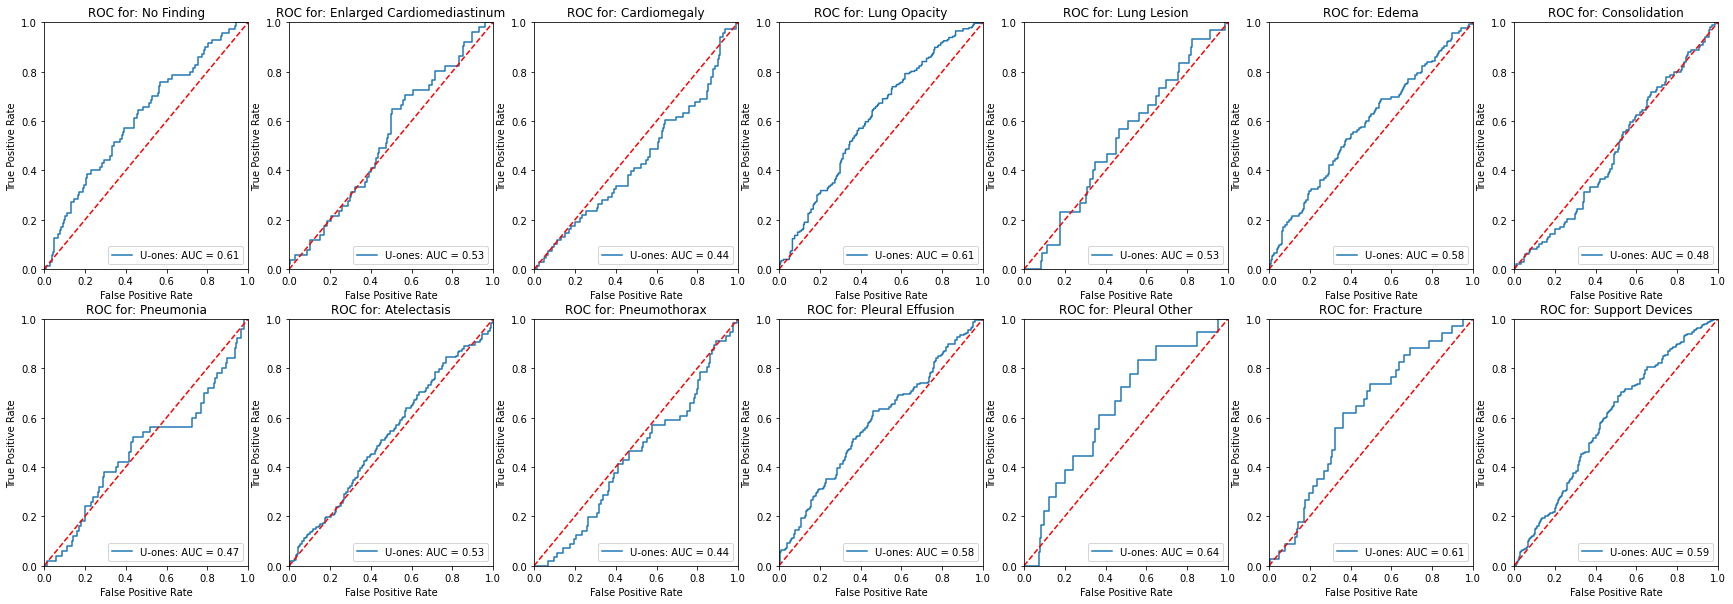

In [62]:
plot_roc(outGT1_cnn_v2, outPRED1_cnn_v2)

In [ ]:
mlp_600_400_200 = MLNetwork_mult2_h(nnClassCount, 600, 400, 200).cuda()
mlp_900_450_300 = MLNetwork_mult2_h(nnClassCount, 900, 450, 300).cuda()
mlp_1200_900_600 = MLNetwork_mult2_h(nnClassCount, 1200, 900, 600).cuda()

print(mlp_600_400_200)
print(mlp_900_450_300)
print(mlp_1200_900_600)

MLNetwork_mult2_h(
  (l1): Linear(in_features=150528, out_features=600, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=600, out_features=400, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=400, out_features=200, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=200, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork_mult2_h(
  (l1): Linear(in_features=150528, out_features=900, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=900, out_features=450, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=450, out_features=300, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=300, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork_mult2_h(
  (l1): Linear(in_features=150528, out_features=1200, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=1200, out_features=900, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=900, out_features=600, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=600, out_features=14,

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_600_400_200, losst_600_400_200, losse_600_400_200 = CheXpertTrainer.train(mlp_600_400_200, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_600_400_200, outPRED1_600_400_200 = CheXpertTrainer.test(mlp_600_400_200, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

Streaming output truncated to the last 5000 lines.
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
2 % batches computed
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])
70
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 2

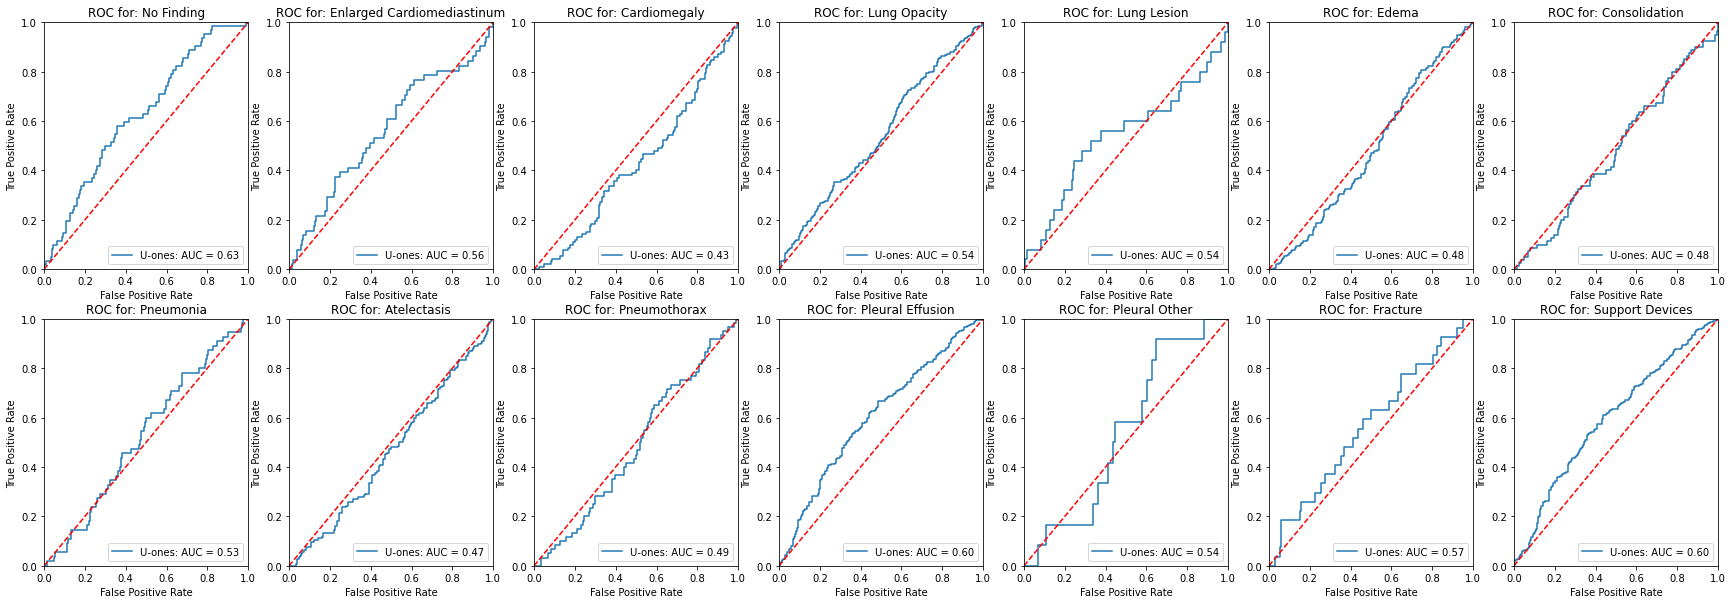

In [ ]:
plot_roc(outGT1_600_400_200, outPRED1_600_400_200)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_900_450_300, losst_900_450_300, losse_900_450_300 = CheXpertTrainer.train(mlp_900_450_300, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_900_450_300, outPRED1_900_450_300 = CheXpertTrainer.test(mlp_900_450_300, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
2 % batches computed
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])
70
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 2

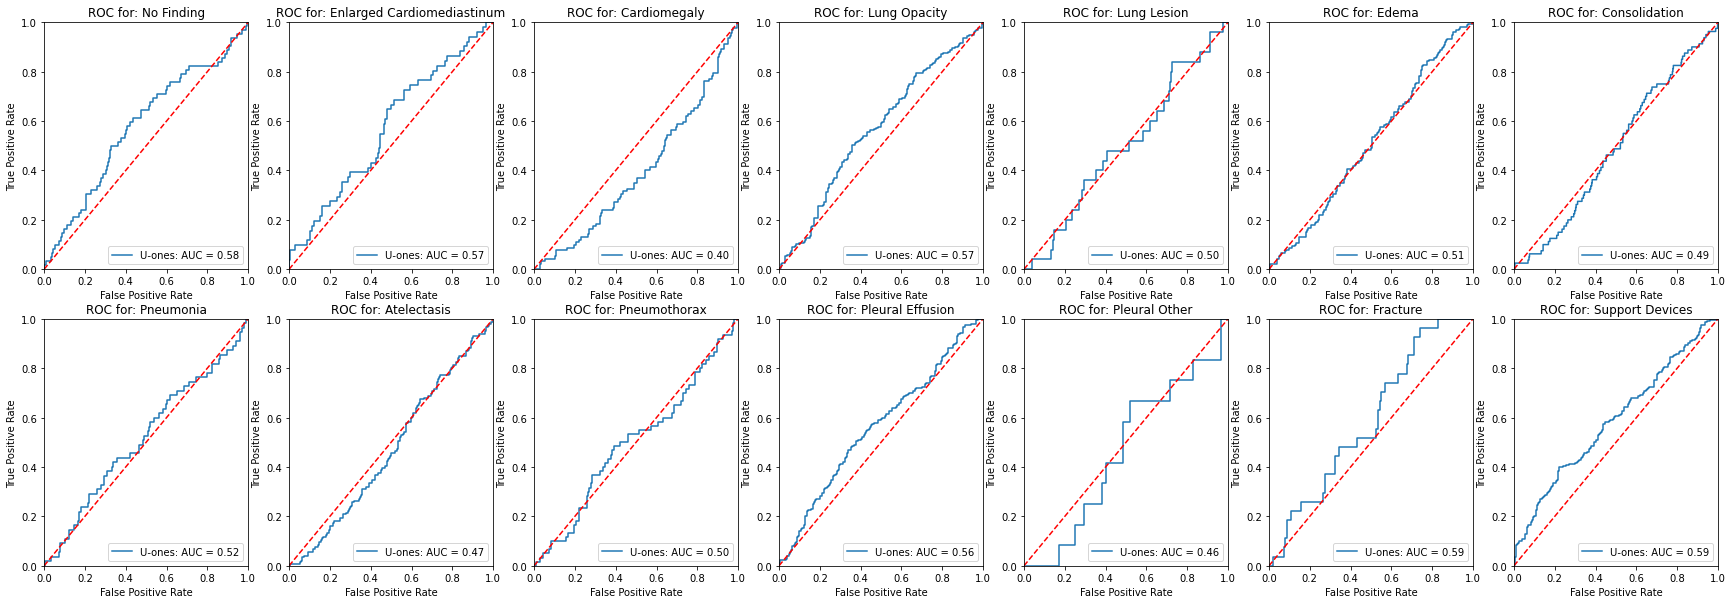

In [ ]:
  plot_roc(outGT1_900_450_300, outPRED1_900_450_300)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_1200_900_600, losst_1200_900_600, losse_1200_900_600 = CheXpertTrainer.train(mlp_1200_900_600, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_1200_900_600, outPRED1_1200_900_600 = CheXpertTrainer.test(mlp_1200_900_600, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
2 % batches computed
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])
70
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 2

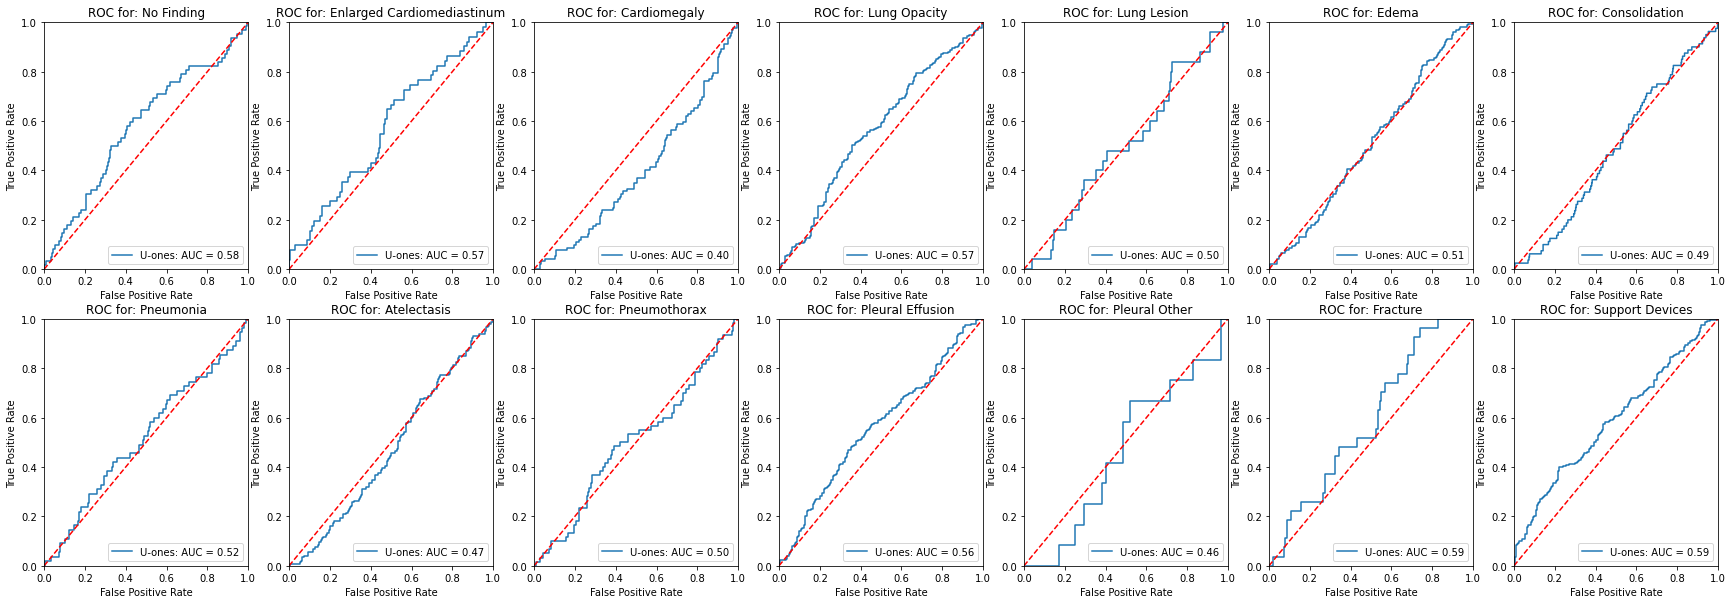

In [ ]:
plot_roc(outGT1_900_450_300, outPRED1_900_450_300)

In [ ]:
# initialize and load the model
model = Network(nnClassCount).cuda()
model

Network(
  (output): Linear(in_features=150528, out_features=14, bias=True)
  (sigm): Sigmoid()
)

In [ ]:
model_cnn = simple_CNN(nnClassCount).cuda()
model_cnn

simple_CNN(
  (con1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pol1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (linear_layer1): Linear(in_features=238144, out_features=122, bias=True)
  (linear_layer2): Linear(in_features=122, out_features=52, bias=True)
  (linear_layer3): Linear(in_features=52, out_features=14, bias=True)
  (sigm): Sigmoid()
)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_cnn, losst_cnn, losse_cnn = CheXpertTrainer.train(model_cnn, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_cnn, outPRED1_cnn = CheXpertTrainer.test(model_cnn, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

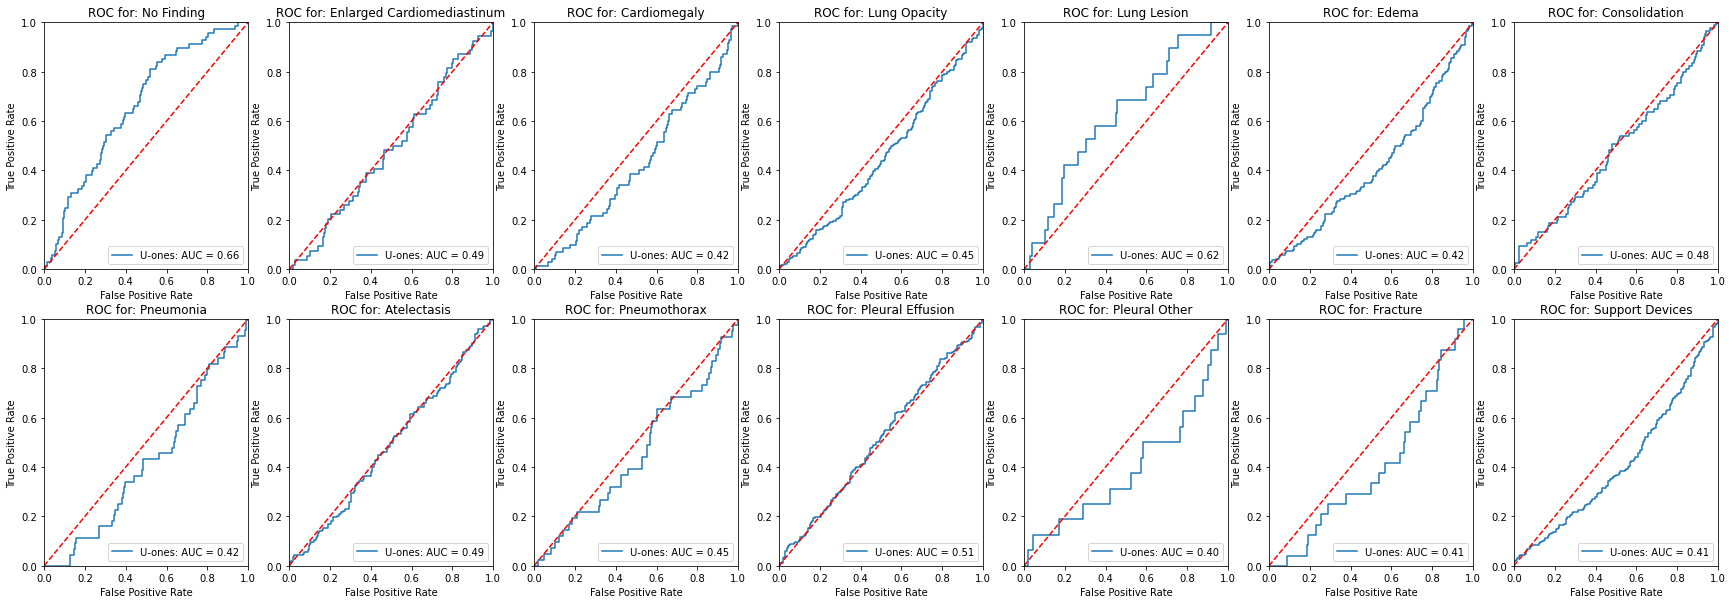

In [ ]:
  plot_roc(outGT1_cnn, outPRED1_cnn)

In [ ]:
model_densenet121 = DenseNet121(nnClassCount).cuda()

timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_dense_net, losst_dense_net, losse_dense_net = CheXpertTrainer.train(model_densenet121, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)
outGT1_dense_net, outPRED1_dense_net = CheXpertTrainer.test(model_densenet121, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)

In [ ]:
model_densenet121 = DenseNet121(nnClassCount).cuda()

#x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False).to(device)
#out = model_densenet121(x)
#make_dot(out) 

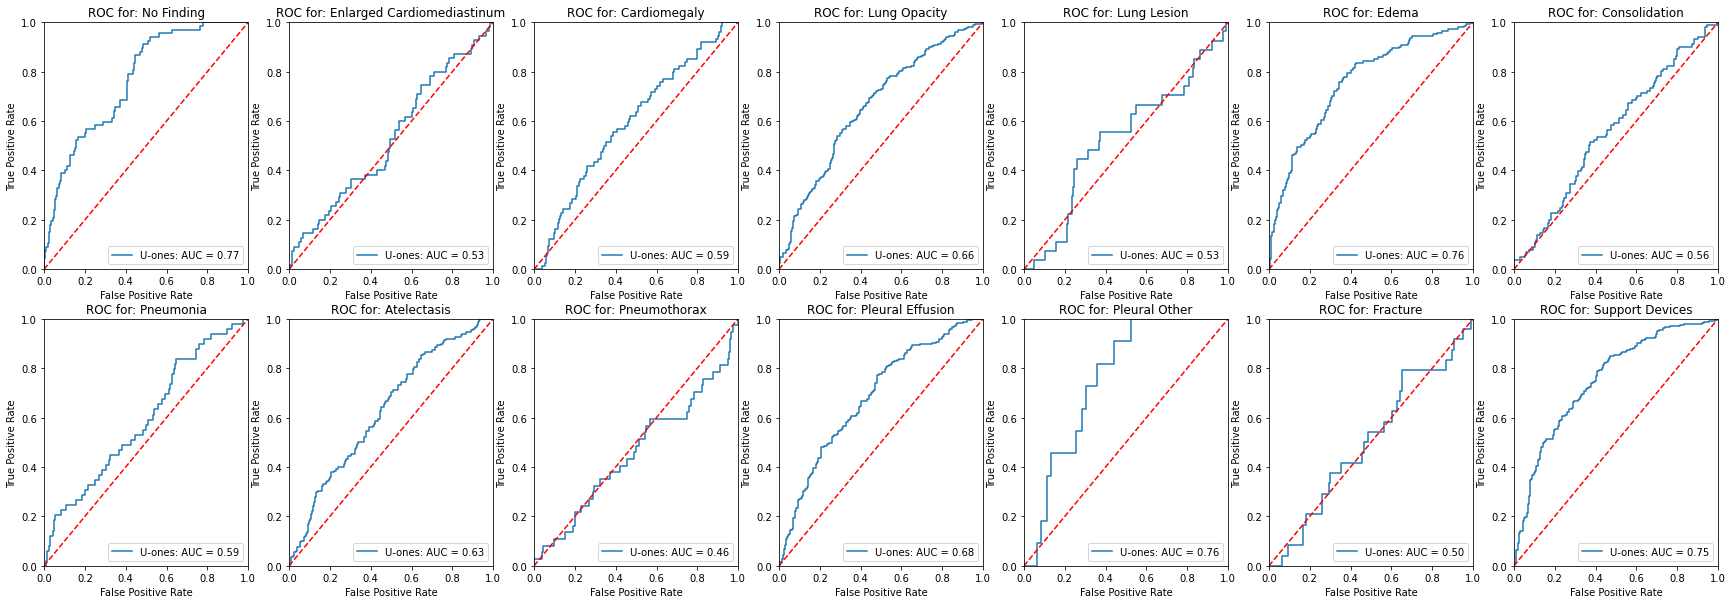

In [ ]:
  plot_roc(outGT1_dense_net, outPRED1_dense_net)

In [72]:
model_slp = Network(nnClassCount).cuda()

In [ ]:
!pip install torchviz

In [74]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime


batch_slp, losst_slp, losse_slp = CheXpertTrainer.train(model_slp, dataLoaderTrain, dataLoaderVal, nnClassCount, 1, timestampLaunch, checkpoint = None)
outGT1_slp, outPRED1_slp = CheXpertTrainer.test(model_slp, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
0
1 % batches computed
35
2 % batches computed
70
3 % batches computed
105
4 % batches computed
140
5 % batches computed
175
6 % batches computed
210
7 % batches computed
245
8 % batches computed
280
9 % batches computed
315
10 % batches computed
350
11 % batches computed
385
12 % batches computed
420
13 % batches computed
455
14 % batches computed
490
15 % batches computed
525
16 % batches computed
560
17 % batches computed
595
18 % batches computed
630
19 % batches computed
665
20 % batches computed
700
21 % batches computed
735
22 % batches computed
770
23 % batches computed
805
24 % batches computed
840
25 % batches computed
875
26 % batches computed
910
27 % batches computed
945
28 % batches computed
980
29 % batches computed
1015
30 % batches computed
1050
31 % batches computed
1085
32 % batches computed
1120
33 % batches computed
1155
34 % batches computed
1190
35 % batches computed
1225
36 % batches computed
1260
Epoch [1] [save] [20012021-063828] loss= ten

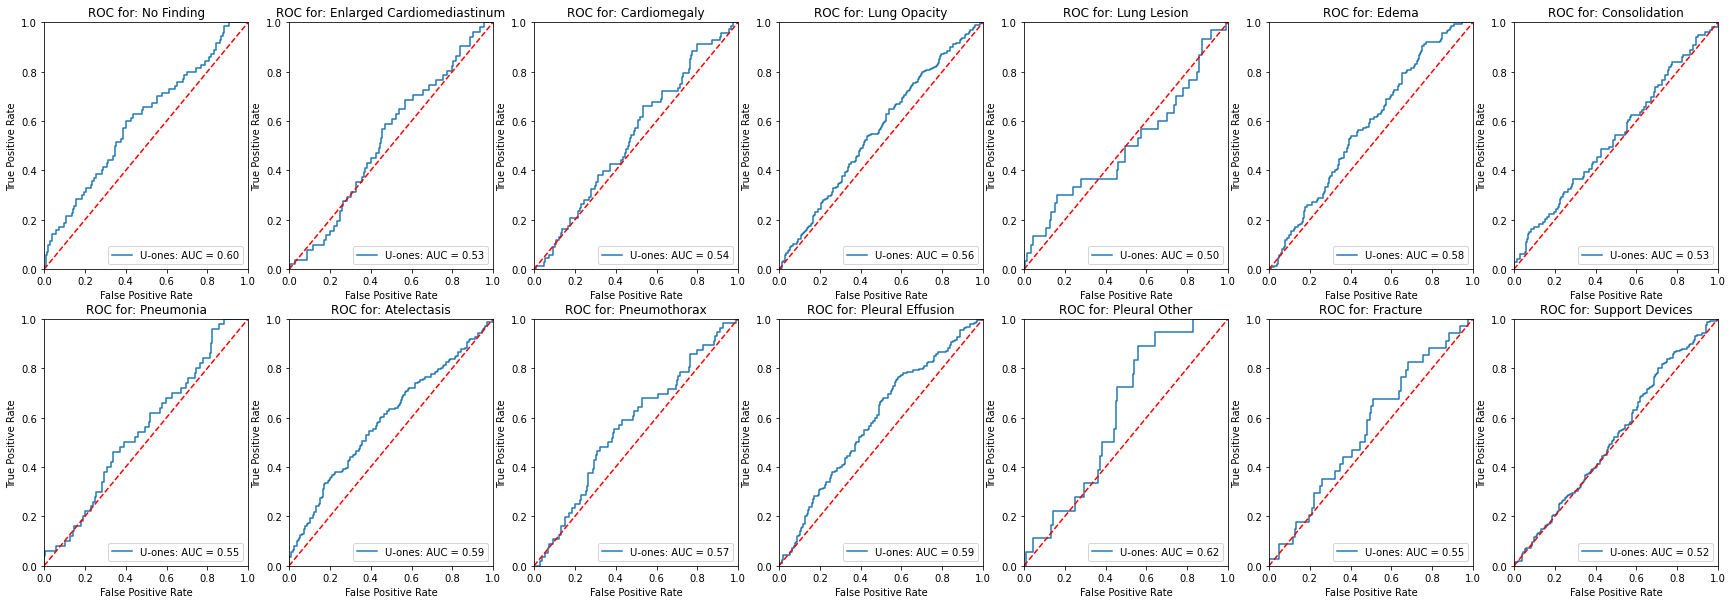

In [75]:
plot_roc(outGT1_slp, outPRED1_slp)

In [77]:
# initialize and load the model
model_mlp_100 = MLNetwork(nnClassCount, 100).cuda()
model_mlp_150 = MLNetwork(nnClassCount, 150).cuda()
model_mlp_200 = MLNetwork(nnClassCount, 200).cuda()

print(model_mlp_100)
print(model_mlp_150)
print(model_mlp_200)

MLNetwork(
  (l1): Linear(in_features=150528, out_features=100, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=100, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork(
  (l1): Linear(in_features=150528, out_features=150, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=150, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork(
  (l1): Linear(in_features=150528, out_features=200, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=200, out_features=14, bias=True)
  (sigm): Sigmoid()
)


MLNetwork_mult_h(
  (l1): Linear(in_features=150528, out_features=300, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=300, out_features=200, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=200, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork_mult_h(
  (l1): Linear(in_features=150528, out_features=900, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=900, out_features=600, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=600, out_features=14, bias=True)
  (sigm): Sigmoid()
)
MLNetwork_mult_h(
  (l1): Linear(in_features=150528, out_features=1800, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=1800, out_features=900, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=900, out_features=14, bias=True)
  (sigm): Sigmoid()
)


In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch, losst, losse = CheXpertTrainer.train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)


In [ ]:
outGT1, outPRED1 = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


In [78]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_, losst, losse = CheXpertTrainer.train(model_mlp_100, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
0
1 % batches computed
35
2 % batches computed
70
3 % batches computed
105
4 % batches computed
140
5 % batches computed
175
6 % batches computed
210
7 % batches computed
245
8 % batches computed
280
9 % batches computed
315
10 % batches computed
350
11 % batches computed
385
12 % batches computed
420
13 % batches computed
455
14 % batches computed
490
15 % batches computed
525
16 % batches computed
560
17 % batches computed
595
18 % batches computed
630
19 % batches computed
665
20 % batches computed
700
21 % batches computed
735
22 % batches computed
770
23 % batches computed
805
24 % batches computed
840
25 % batches computed
875
26 % batches computed
910
27 % batches computed
945
28 % batches computed
980
29 % batches computed
1015
30 % batches computed
1050
31 % batches computed
1085
32 % batches computed
1120
33 % batches computed
1155
34 % batches computed
1190
35 % batches computed
1225
36 % batches computed
1260
Epoch [1] [save] [20012021-064444] loss= ten

In [79]:
outGT1_mlp_100, outPRED1_mlp_100 = CheXpertTrainer.test(model_mlp_100, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


AUROC mean  0.5769388750183928
No Finding   0.6585714285714286
Enlarged Cardiomediastinum   0.4321586095462684
Cardiomegaly   0.57645697167756
Lung Opacity   0.5856695303920935
Lung Lesion   0.5119148936170212
Edema   0.6618366311516997
Consolidation   0.5491574095065367
Pneumonia   0.5774666666666667
Atelectasis   0.5984444566591546
Pneumothorax   0.5651544401544402
Pleural Effusion   0.6340277413373914
Pleural Other   0.5703088981097281
Fracture   0.6096945215854582
Support Devices   0.5462820512820513


In [ ]:
test_1 = outGT1_mlp_100.tolist()
test_2 = outPRED1_mlp_100.tolist()


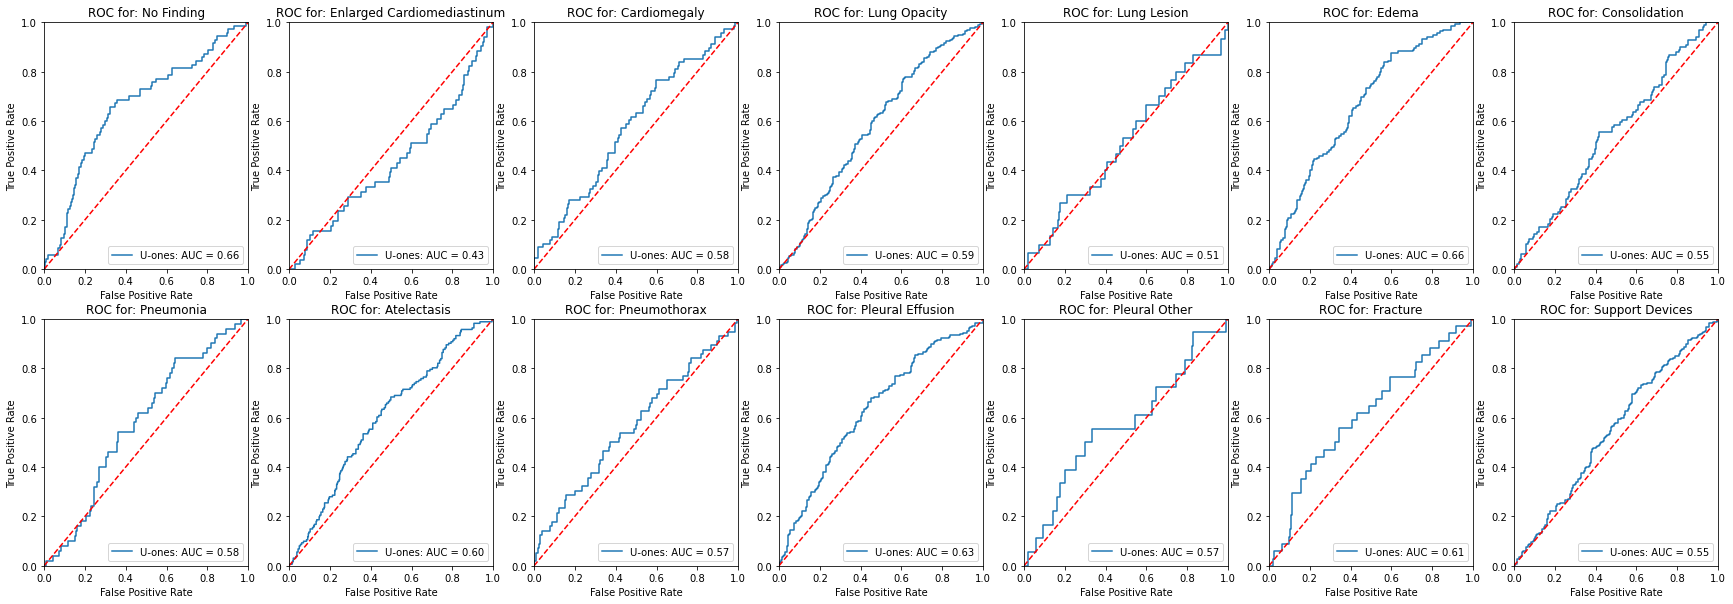

In [80]:
plot_roc(outGT1_mlp_100, outPRED1_mlp_100)

In [81]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_, losst_mlp150, losse_mlp150 = CheXpertTrainer.train(model_mlp_150, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
0
1 % batches computed
35
2 % batches computed
70
3 % batches computed
105
4 % batches computed
140
5 % batches computed
175
6 % batches computed
210
7 % batches computed
245
8 % batches computed
280
9 % batches computed
315
10 % batches computed
350
11 % batches computed
385
12 % batches computed
420
13 % batches computed
455
14 % batches computed
490
15 % batches computed
525
16 % batches computed
560
17 % batches computed
595
18 % batches computed
630
19 % batches computed
665
20 % batches computed
700
21 % batches computed
735
22 % batches computed
770
23 % batches computed
805
24 % batches computed
840
25 % batches computed
875
26 % batches computed
910
27 % batches computed
945
28 % batches computed
980
29 % batches computed
1015
30 % batches computed
1050
31 % batches computed
1085
32 % batches computed
1120
33 % batches computed
1155
34 % batches computed
1190
35 % batches computed
1225
36 % batches computed
1260
Epoch [1] [save] [20012021-074815] loss= ten

In [82]:
outGT1_mlp_150, outPRED1_mlp_150 = CheXpertTrainer.test(model_mlp_150, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


AUROC mean  0.5811931477212703
No Finding   0.6341196013289038
Enlarged Cardiomediastinum   0.5009825756583257
Cardiomegaly   0.5944308278867102
Lung Opacity   0.5786124927330276
Lung Lesion   0.6149645390070921
Edema   0.630806697108067
Consolidation   0.5531121690722688
Pneumonia   0.5541333333333334
Atelectasis   0.5904468751717694
Pneumothorax   0.5573922136422137
Pleural Effusion   0.609120008395865
Pleural Other   0.6100737667127709
Fracture   0.5410249936884625
Support Devices   0.5674839743589744


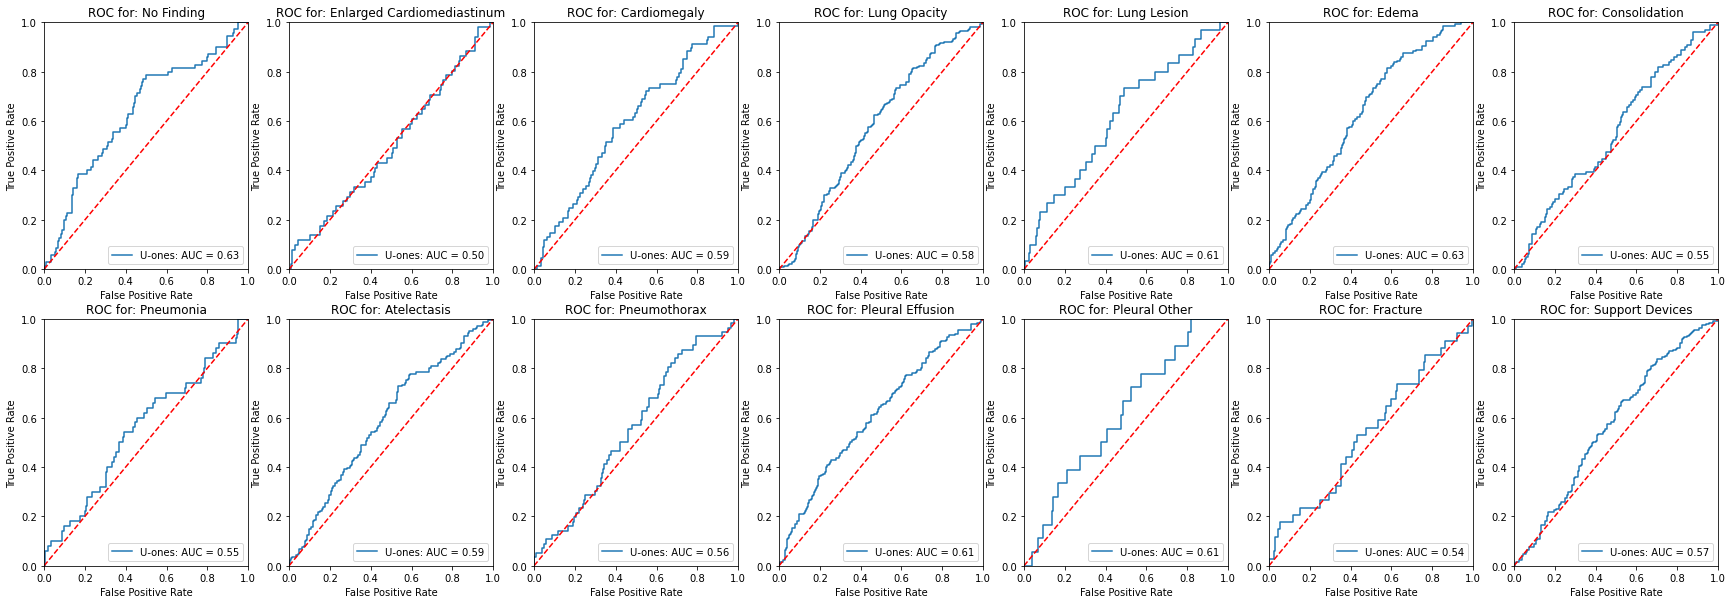

In [83]:
plot_roc(outGT1_mlp_150, outPRED1_mlp_150)

In [ ]:
# now trying the optimal hidden state neuron size with the recommendation found online
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

model_mlp_256_256_2 = MLNetwork(nnClassCount, 256*256*2).cuda()



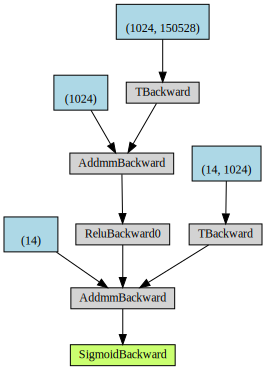

In [30]:
model_mlp_32_32 = MLNetwork(nnClassCount, 32*32).cuda()
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False).to(device)
out = model_mlp_32_32(x)
make_dot(out) 

In [85]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_32_32, losst_32_32, losse_32_32 = CheXpertTrainer.train(model_mlp_32_32, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
0
1 % batches computed
35
2 % batches computed
70
3 % batches computed
105
4 % batches computed
140
5 % batches computed
175
6 % batches computed
210
7 % batches computed
245
8 % batches computed
280
9 % batches computed
315
10 % batches computed
350
11 % batches computed
385
12 % batches computed
420
13 % batches computed
455
14 % batches computed
490
15 % batches computed
525
16 % batches computed
560
17 % batches computed
595
18 % batches computed
630
19 % batches computed
665
20 % batches computed
700
21 % batches computed
735
22 % batches computed
770
23 % batches computed
805
24 % batches computed
840
25 % batches computed
875
26 % batches computed
910
27 % batches computed
945
28 % batches computed
980
29 % batches computed
1015
30 % batches computed
1050
31 % batches computed
1085
32 % batches computed
1120
33 % batches computed
1155
34 % batches computed
1190
35 % batches computed
1225
36 % batches computed
1260
Epoch [1] [save] [20012021-085641] loss= ten

In [86]:
outGT1_mlp_32_32, outPRED1_mlp_32_32 = CheXpertTrainer.test(model_mlp_32_32, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


AUROC mean  0.5986294712643516
No Finding   0.667142857142857
Enlarged Cardiomediastinum   0.5091925411590026
Cardiomegaly   0.5681168300653595
Lung Opacity   0.6050804211614237
Lung Lesion   0.5265248226950355
Edema   0.6659360730593608
Consolidation   0.5285019773797829
Pneumonia   0.6002666666666666
Atelectasis   0.5935066600707232
Pneumothorax   0.5549790862290863
Pleural Effusion   0.6507145230973747
Pleural Other   0.7286768095896727
Fracture   0.6090002524614996
Support Devices   0.573173076923077


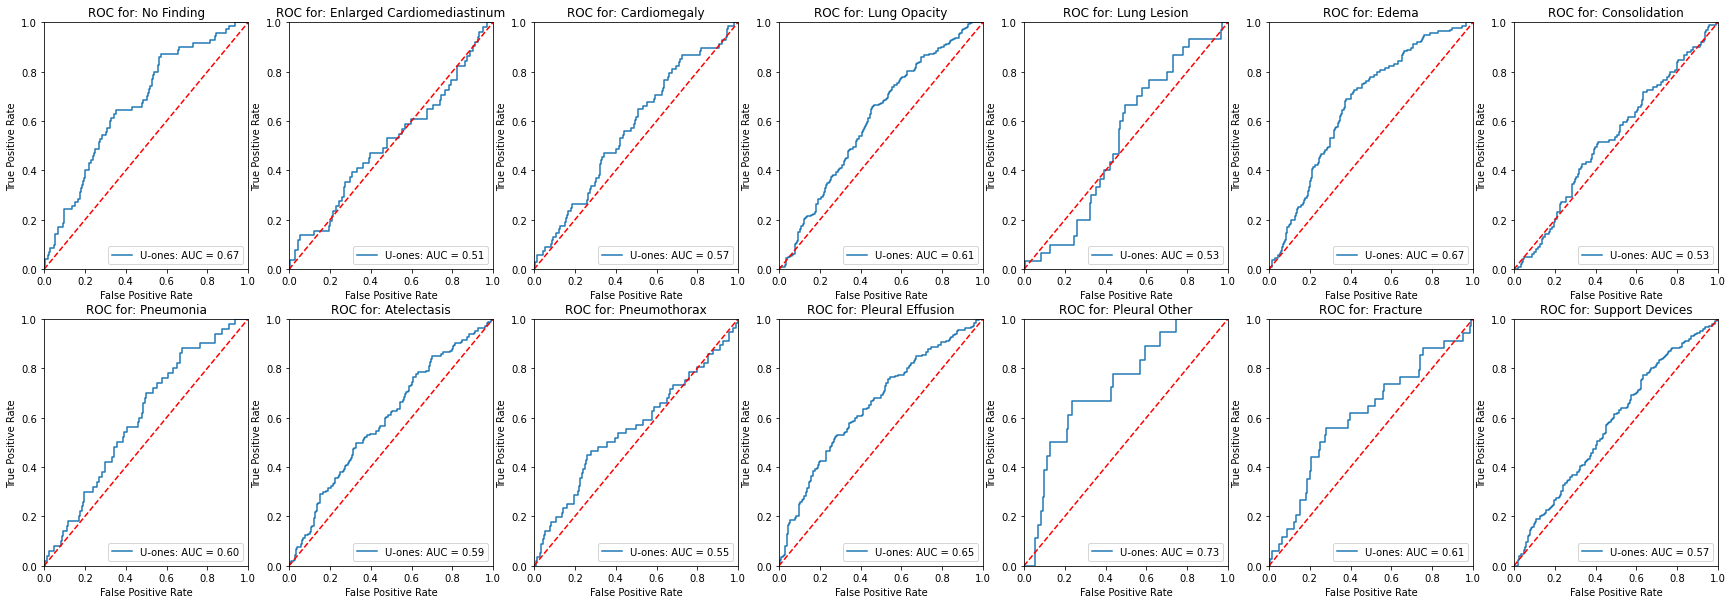

In [87]:
plot_roc(outGT1_mlp_32_32, outPRED1_mlp_32_32)

In [ ]:
batch_mlp_256_256_2, losst_256_256_2, losse_256_256_2 = CheXpertTrainer.train(model_mlp_256_256_2, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)


In [ ]:
outGT1_mlp_256_256_2, outPRED1_mlp_256_256_2 = CheXpertTrainer.test(model_mlp_100, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


In [ ]:
plot_roc(outGT1_mlp_256_256_2, outPRED1_mlp_256_256_2)

In [ ]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch_mlp_300_200, losst_300_200, losse_300_200 = CheXpertTrainer.train(model_mlp_300_200, dataLoaderTrain, dataLoaderVal, nnClassCount, 10, timestampLaunch, checkpoint = None)


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([42, 3, 224, 224])
910
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64,

In [ ]:
outGT1_mlp_300_200, outPRED1_mlp_300_200 = CheXpertTrainer.test(model_mlp_300_200, dataLoaderTest, nnClassCount, checkpoint=None, class_names = class_names)


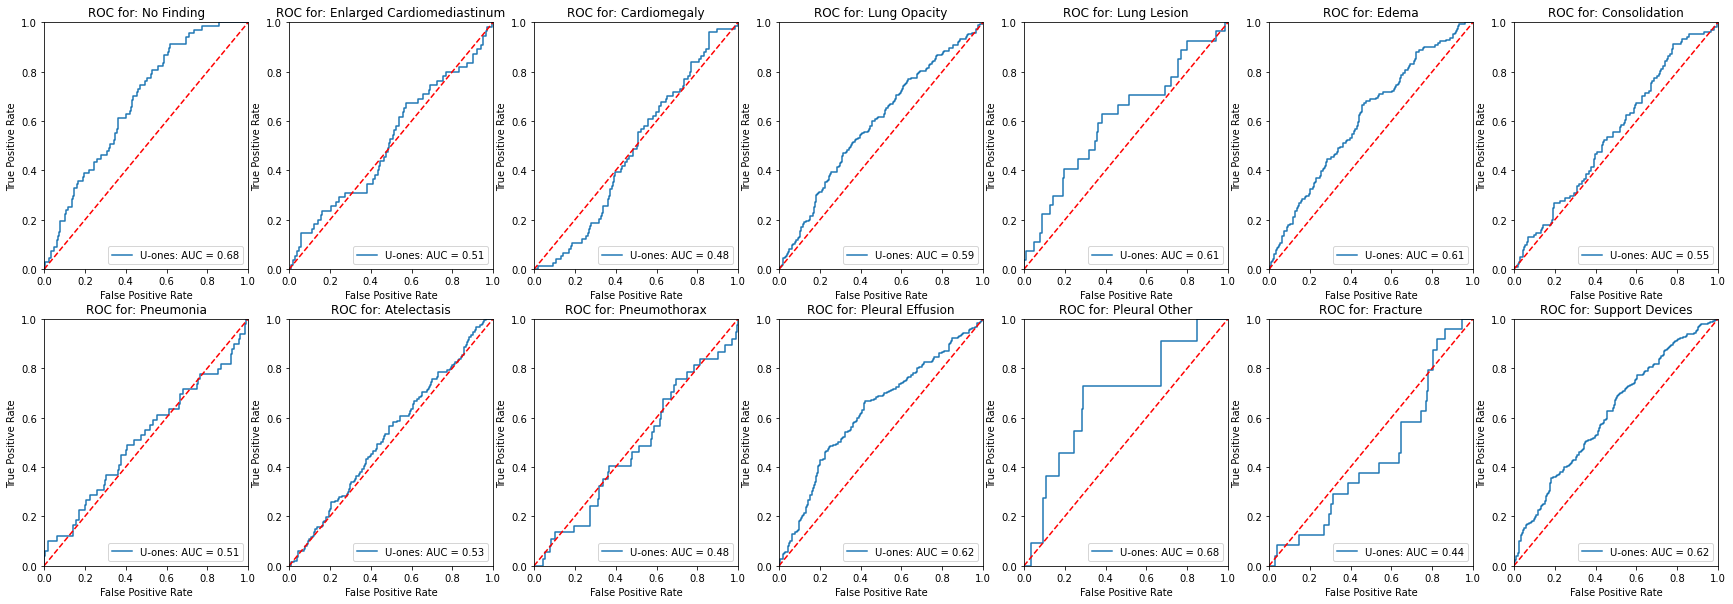

In [ ]:
plot_roc(outGT1_mlp_300_200, outPRED1_mlp_300_200)